# Imports and setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
%matplotlib inline

In [3]:
sns.set_context('talk')

In [4]:
root_dir = Path(os.getcwd()).parent

In [5]:
os.chdir(root_dir)

In [6]:
from src.data import get_session_dataset, get_user_dataset

In [7]:
SEED = 100

# Load data

Load a year's worth of session data (covering all users).

## User data

In [8]:
users_df = get_user_dataset('2019-01-01', '2020-01-01', seed=SEED)

In [9]:
users_df.head()

,activation_date,country,age
user_id,,,
fa668344-5ded-42c5-8efe-9445260d5cd0,2018-03-02,US,41
c9c8f7ca-df12-4dc7-8eda-5d71f6f17819,2018-05-15,US,36
f1975c97-1496-4b0b-8abc-749b3bf2d864,2018-09-21,US,40
e8b7af70-6138-47ba-a859-19f516056113,2018-06-25,US,33
5d5cad44-dace-4f24-ae65-58d0342ca39e,2018-12-27,CA,36


In [10]:
users_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30125 entries, fa668344-5ded-42c5-8efe-9445260d5cd0 to 6a09495f-2a24-4b41-9323-c063496c9ab5
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   activation_date  30125 non-null  datetime64[ns]
 1   country          30125 non-null  object        
 2   age              30125 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 941.4+ KB


## Session data

In [11]:
%%time
session_df = get_session_dataset('2019-01-01', '2020-01-01', users_df=users_df,
                                 seed=SEED)
session_df.head(5)

CPU times: user 36.7 s, sys: 1.59 s, total: 38.3 s
Wall time: 38.4 s


,user_id,session_start_date
session_id,,
3a3cd7d6-a09c-41b2-894e-be1598da1889,d91aff4b-6fb0-4e93-a71c-b9e9dc39d5c2,2019-01-01
b71eef53-060b-4990-85ff-14fa0da60e40,3c4d60ef-071b-42a7-8930-e01f49b112f5,2019-01-01
65960b07-b8aa-4926-8206-3c53c8117fe1,855eac95-1ce5-41a8-a86d-fb8c702f0574,2019-01-01
82e89023-0af4-41ac-8a1d-ca452947b8f6,594adbf4-cb91-4aab-9687-ee473d750e4d,2019-01-01
dedc80b2-2792-4313-bb86-058cce7ab631,a608101b-9965-4877-b0f3-db44b8c50637,2019-01-01


In [12]:
session_df.tail(5)

,user_id,session_start_date
session_id,,
336a791e-b7ca-49c7-8258-f9f9a8c854cc,627207f4-ec09-42a0-8999-10298da9088f,2019-12-31
d0d69a2f-f41a-4419-856d-2ca0c98ab298,86e7380b-d125-4ec4-afad-c59f71e467e8,2019-12-31
4d94d759-5fef-4385-829c-d9500e0361a4,e5924335-b6c9-46ee-aff1-eab40a25f546,2019-12-31
eb57f2eb-05f0-43c5-a1d0-b219f6bedf4b,aac79e8d-1d22-4505-a609-799641ad2fd5,2019-12-31
8d87d3fc-a516-4b75-abe7-746b7d57758b,456eb8a1-3d1e-4b23-9897-3e4d774e535f,2019-12-31


### Sense checks for data generation

In [13]:
session_df.isna().sum()

user_id               0
session_start_date    0
dtype: int64

In [14]:
session_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1233992 entries, 3a3cd7d6-a09c-41b2-894e-be1598da1889 to 8d87d3fc-a516-4b75-abe7-746b7d57758b
Data columns (total 2 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   user_id             1233992 non-null  object        
 1   session_start_date  1233992 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(1)
memory usage: 28.2+ MB


### Join user activation info

In [15]:
session_df = session_df.merge(users_df['activation_date'].rename('user_activation_date'),
                              how='left',
                              left_on=['user_id'], right_index=True)

In [16]:
# month of activation (set day = 1 for datetime)
session_df['user_activation_month'] = (session_df['user_activation_date']
                                       .apply(lambda x: x.replace(day=1)))
# explore vectorised solution another time

# Product analytics

## DAU over time

Get time series for **daily active users (DAU)** and total users in 2019.

In [17]:
dau_ts = (session_df.groupby('session_start_date')
          ['user_id'].nunique())

In [18]:
total_users_ts = (users_df.reset_index()
                  .groupby('activation_date')['user_id']
                  .nunique().cumsum())

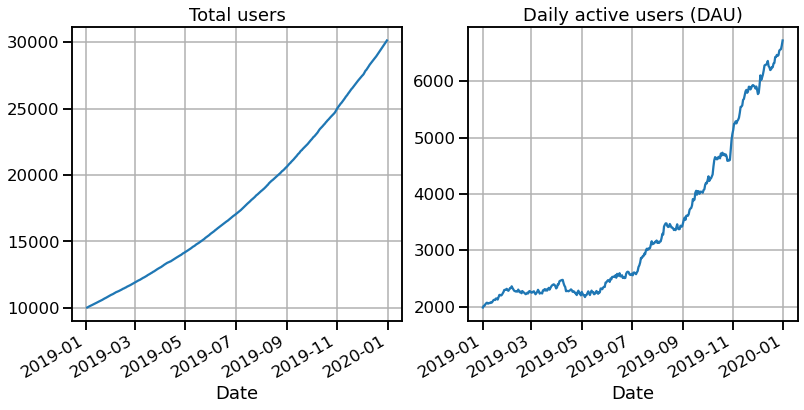

In [19]:
fig, ax = plt.subplots(1,2, figsize=(13,6))
ax[0].plot(total_users_ts[total_users_ts.index >= '2019'])
ax[0].set_title('Total users')
ax[0].set_xlabel('Date')
ax[0].grid()
ax[1].plot(dau_ts)
ax[1].set_title('Daily active users (DAU)')
ax[1].set_xlabel('Date')
ax[1].grid()
fig.autofmt_xdate()
plt.show()

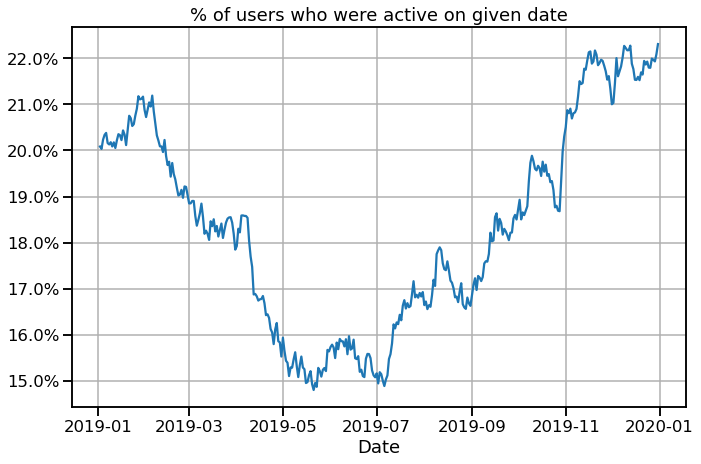

In [20]:
fig, ax = plt.subplots(figsize=(11,7))
ax.plot((dau_ts / total_users_ts).dropna())
ax.set_title('% of users who were active on given date')
ax.set_xlabel('Date')
ax.grid()
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.show()

Engagement as measured by DAU % fell in first half of 2019, but then rebounded in second half of 2019.

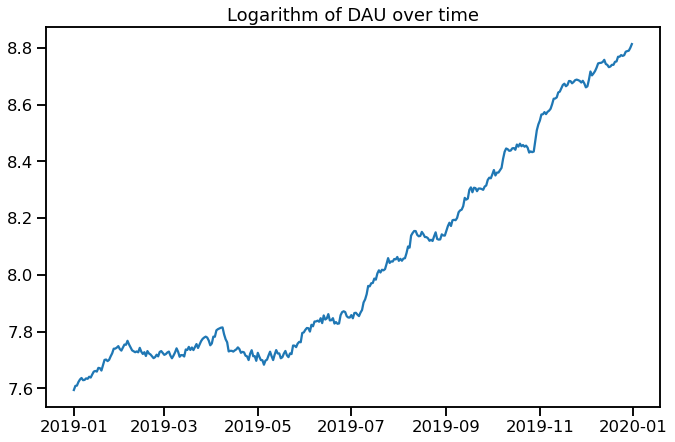

In [21]:
fig, ax = plt.subplots(figsize=(11,7))
ax.set_title('Logarithm of DAU over time')
ax.plot(np.log(dau_ts))
plt.show()

- DAU growth was stagnant in first half of 2019.
- DAU increased steadily across second half of 2019.

## User retention curves

TODO:
- [ ] Remove index vals from `data` if date + n days < max session date

In [22]:
def get_n_day_retention_data(filter_condition, *, session_df, n):
    # Examine a cohort of (unique) users based on filter condition
    ids_list = np.unique(session_df.query(filter_condition)
                         .loc[:, 'user_id']
                         .tolist())
    
    df = (session_df[(session_df['user_id'].isin(ids_list)) &
                     (session_df['user_activation_date'] >= session_df['session_start_date'].min())]
          .copy())
    
    # Add in activation date and calculate retention
    df['n_days'] = (df['session_start_date'] - df['user_activation_date']).dt.days
    
    # At granularity of days, count the number of DISTINCT users active
    data = (df
            .query('n_days <= {}'.format(n))
            .groupby('n_days')['user_id'].nunique())
    data = data.div(len(ids_list))  # make the amounts a %
    
    # left join value counts to desired index
    data = (pd.Series(data, index=pd.Index(range(n+1)))
            .fillna(0))
    return data

In [23]:
def plot_n_day_retention(filter_condition, *, session_df, n, ax=None):
    if ax is None:
        ax = plt.gca()
    
    data = get_n_day_retention_data(filter_condition,
                                    session_df=session_df,
                                    n=n)

    # Plot details
    ax.set_ylabel('Percentage of users still active')
    ax.set_xlabel('Days after activation')
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
    ax.set_ylim(bottom=0)
    return ax.plot(data, label=str(filter_condition))

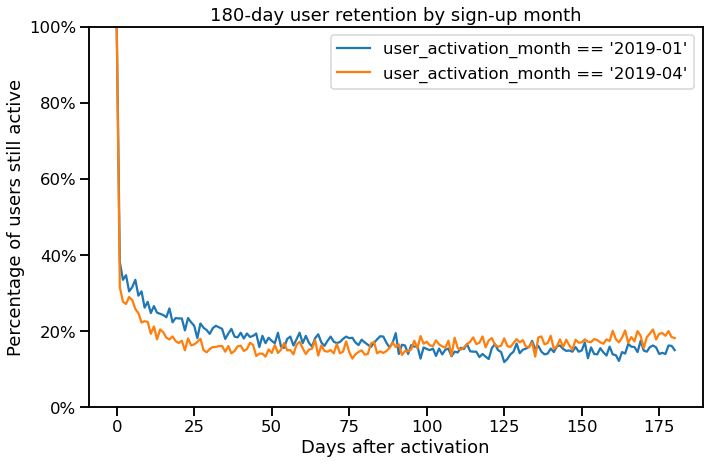

In [28]:
fig, ax = plt.subplots(figsize=(11,7))
plot_n_day_retention("user_activation_month == '2019-01'",
                     session_df=session_df, n=180, ax=ax)
plot_n_day_retention("user_activation_month == '2019-04'",
                     session_df=session_df, n=180, ax=ax)
ax.set_title('180-day user retention by sign-up month')
ax.legend()
plt.show()

- Users who signed up in April 2019 had lower engagement in first 30 days than sign-ups in January 2019.
- However, their engagement was higher after 6 months (a 'smile graph'?)